In [2]:
!pip install pandas numpy scikit-learn

In [3]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

df1 = pd.read_csv('fraudTrain.csv', index_col=0)
df2 = pd.read_csv('fraudTest.csv', index_col=0)

def preprocess(df):
  #had to drop merchant and city because it became too heavy
  df = df.drop(['trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'trans_num', 'job', 'merchant', 'city'], axis=1)
  cata_cols = ['category', 'gender', 'state']
  df = pd.get_dummies(df, columns=cata_cols, drop_first=True)

  #map alone did not work
  for col in df.select_dtypes(include='object').columns:
      if set(df[col].unique()) <= {'true', 'false'}:
          df[col] = df[col].map({'true': 1, 'false': 0})

  #was in string format so converted into date format for consistency
  df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
  ref_date = pd.to_datetime('2020-01-01')
  df['age'] = (ref_date - df['dob']).dt.days // 365
  df = df.drop('dob', axis=1)

  #converted boolean to int F = 0, T = 1
  for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(int)

  df = df.dropna(subset=['is_fraud'])
  df['is_fraud'] = df['is_fraud'].astype(int)
  return df

df1 = preprocess(df1)
df2 = preprocess(df2)

df2 = df2.reindex(columns=df1.columns, fill_value=0)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1.drop('is_fraud', axis=1))
y = df1['is_fraud'].values

x_data_test = scaler.transform(df2.drop('is_fraud', axis=1))
y_data_test = df2['is_fraud'].values

X_train = x_scaled
y_train = y

X_test = x_data_test
y_test = y_data_test

#very unbalanced dataset hence used class_weight
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_data_pred = model.predict(x_data_test)



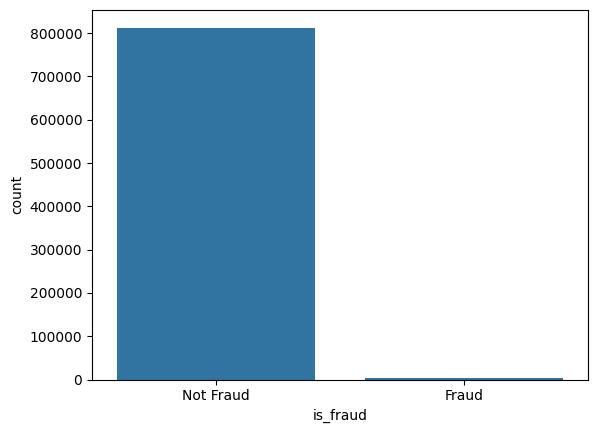

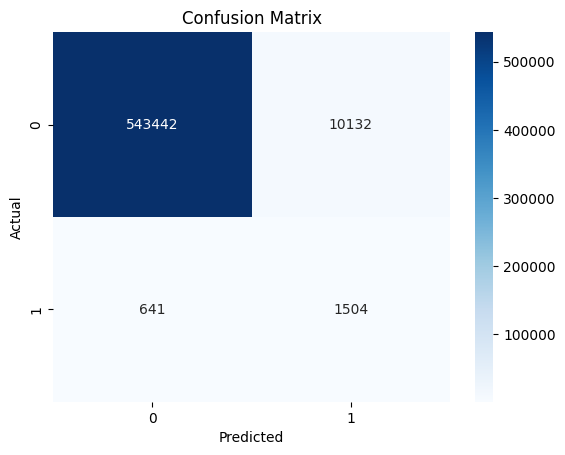

[[543442  10132]
 [   641   1504]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.13      0.70      0.22      2145

    accuracy                           0.98    555719
   macro avg       0.56      0.84      0.60    555719
weighted avg       1.00      0.98      0.99    555719

0.9806143032719774
0.892257923744229


In [5]:
#Visualization and Conclusions
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
#To show data imbalance
sns.countplot(x='is_fraud', data=df1)
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))
print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
#With train_test_split:
#Conclusions for using only training data to test (20% - test, 80%-train)
#Accuracy 89% could have been increased if used RandomForest or some other model or a better balanced dataset
#ROC AUC score 91% used because of the imbalanced data

#By using the test and train csv
#Conclusions
#Accuracy: 98%
#roc auc score: 89%

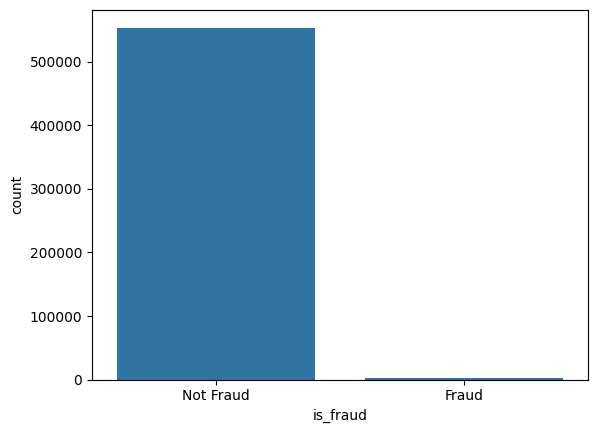

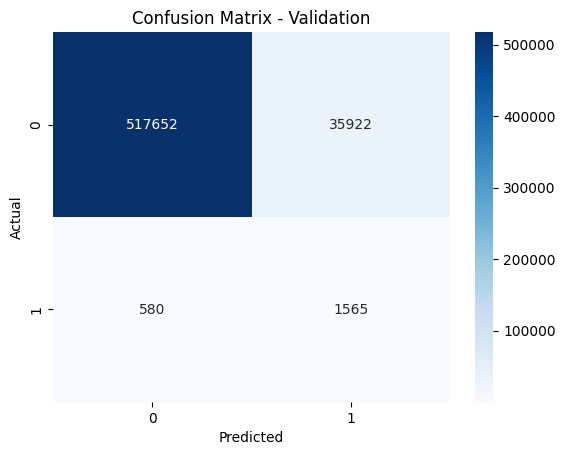

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    553574
           1       0.04      0.73      0.08      2145

    accuracy                           0.93    555719
   macro avg       0.52      0.83      0.52    555719
weighted avg       1.00      0.93      0.96    555719

Accuracy:  0.9343157243139069
ROC AUC:  0.8954117512778142


In [ ]:
#Visualization and Conclusions for fraudTest.csv
sns.countplot(x='is_fraud', data=df2)
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()
sns.heatmap(confusion_matrix(y_data_test, y_data_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report:\n",classification_report(y_data_test, y_data_pred))
print("Accuracy: ",accuracy_score(y_data_test,y_data_pred))
print("ROC AUC: ",roc_auc_score(y_data_test, model.predict_proba(x_data_test)[:, 1]))
#Conclusions
#Accuaracy 93%
#ROC AUC score 90%